In [147]:
import pandas as pd
import numpy as np
import glob
import os
from pathlib import Path
from chart_studio import plotly 
from  plotly.offline import iplot
from sklearn import svm
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn import ensemble




In [110]:
#path="C:\Users\julia\OneDrive\Desktop\DSP\Project\BH"
# path = r'C:\Users\julia\OneDrive\Desktop\DSP\Project\Serves'
# print(path)
# csv_files=glob.glob( path +"/*.csv")
# df_list = (pd.read_csv(file) for file in csv_files)
def read_data(folder_name):
    # convert json to csv:
    path=os.getcwd()+"\\"+folder_name
    for filename in os.listdir(path): 
        root, ext = os.path.splitext(filename) 
        if ext == '.json': 
            file = pd.read_json(path+"\\"+filename,orient='records')
            file=file.loc[file['sensor']=="Gyroscope"] # Select gyro data 
            file.to_csv(path+"\\"+root + '.csv',index=False,columns=['seconds_elapsed','z','y','x'])

    examples = []
    example_names = []
    for f in sorted(glob.glob(folder_name + "/*.csv")):
        #print(f)
        filename = f[f.find('/') + 1:-4]
        #print(filename)
        example = pd.read_csv(f, header=0)
        # print(trace.columns)
        # print(filename)
        #trace=trace.drop(columns="time")#print(trace.shape)
        example = example.apply(pd.to_numeric, errors='coerce')
        #trace["accel"] = np.linalg.norm((trace["accel_ms2_x"], trace["accel_ms2_y"], trace["accel_ms2_z"]), axis=0)
        #trace["gyro"] = np.linalg.norm((trace['gyro_degs_x'], trace[u'gyro_degs_y'], trace[u'gyro_degs_z']), axis=0)
        # trace["z_gyro"]=trace["z"]
        # trace["y_gyro"]=trace["y"]
        # trace["x_gyro"]=trace["x"]
        # trace=trace.drop(columns=["x", "y","z"])
        #normalized = min_max_scaler.fit_transform(trace['accel_ms2_z'].values.reshape(-1, 1))
        #normalized = normalized[:, 0]
        #trace["normalized_accel_z"] = normalized
        example_names.append(filename)
        examples.append(example)
    return example_names, examples

swings=["Serves","BH","FH"]
examples = {}
example_names = {}
for swing in swings:
    example_names[swing], examples[swing] = read_data(swing)
#print(examples)
# json_pattern = os.path.join(path_to_json,'*.json')
# file_list = glob.glob(json_pattern)
# temp=pd.DataFrame()
# dfs=[]
# for file in file_list:
#     data = pd.read_json(file, lines=True)
#     dfs.append(data)
# temp = pd.concat(dfs, ignore_index=True) # concatenate all the data frames in the li
# temp.head()


32
30
20


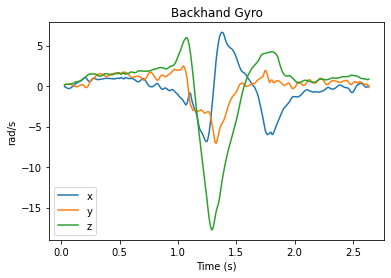

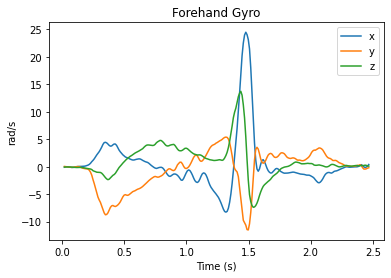

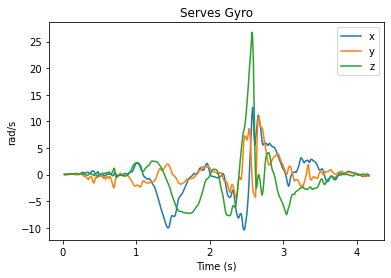

In [111]:
#examples["BH"][0].head()
print(len(examples["BH"]))
print(len(examples["FH"]))
print(len(examples["Serves"]))

#subplot(1,3,1)
examples["BH"][5].plot(x='seconds_elapsed',y=['x','y','z'],title="Backhand Gyro",ylabel="rad/s",xlabel="Time (s)")
examples["FH"][5].plot(x='seconds_elapsed',y=['x','y','z'],title="Forehand Gyro",ylabel="rad/s",xlabel="Time (s)")
examples["Serves"][5].plot(x='seconds_elapsed',y=['x','y','z'],title="Serves Gyro",ylabel="rad/s",xlabel="Time (s)")
#figplots=ipw.HBox([fig1,fig2,fig3])

In [112]:
# for i in range(len(examples['BH'])):
#     examples["BH"][i].plot(x='seconds_elapsed',y=['x','y','z'],title="Backhand",ylabel="rad/s",xlabel="Time (s)")
    
#for i in range(len(examples["FH"])):
    #examples["FH"][i].plot(x='seconds_elapsed',y=['x','y','z'],title="Forehand",ylabel="rad/s",xlabel="Time (s)")

#for i in range(len(examples["Serves"])):
#    examples["Serves"][i].plot(x='seconds_elapsed',y=['x','y','z'],title="Serve",ylabel="rad/s",xlabel="Time (s)"")


In [113]:
print(examples)

{'Serves': [     seconds_elapsed         z         y         x
0           0.029338  0.100660 -0.124310  0.066769
1           0.039348  0.088001 -0.071826  0.022227
2           0.049358  0.025574 -0.029625  0.023032
3           0.059337 -0.008626 -0.008803  0.076843
4           0.069347  0.047880  0.032477  0.096602
..               ...       ...       ...       ...
442         4.448786 -0.048533 -0.057671  0.161050
443         4.458796 -0.068403 -0.157117  0.208785
444         4.468806 -0.067122 -0.265479  0.203078
445         4.478785 -0.070441 -0.268338  0.205456
446         4.488795 -0.049853 -0.285698  0.231054

[447 rows x 4 columns],      seconds_elapsed         z         y         x
0           0.023564  0.110593  0.003090  0.025851
1           0.033574  0.107049  0.011521 -0.071872
2           0.043553  0.133437 -0.004615 -0.092600
3           0.053563  0.153271 -0.007387 -0.039649
4           0.063573  0.154818  0.005958 -0.009946
..               ...       ...       ...     

20.898637771606445
20.898637771606445
20
30


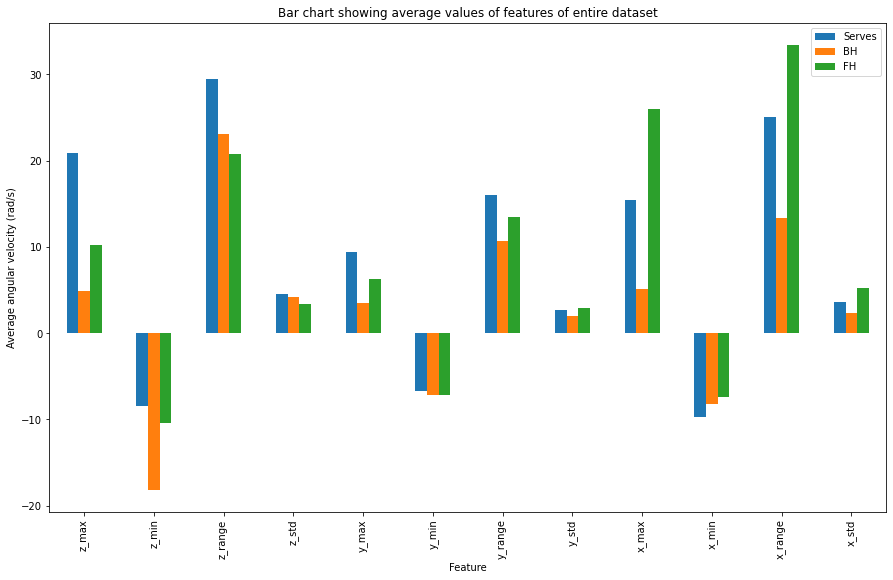

In [146]:


def calc_features(example):
    # if get_headers==True:
    #     return ['max','min','range','std']
    feature_vals=[]
    feature_vals.append(max(example))
    feature_vals.append(min(example))
    feature_vals.append(max(example)-min(example))
    feature_vals.append(example.std())
    return feature_vals
    
# def get_features(example,get_headers=False):
#     features=[]
#     for col in ['z','y','x']:
#         temp=calc_features(example[col],get_headers)
#         if get_headers:
#             features.extend([x+'_'+ col for x in temp])
#         else:
#             features.extend(temp)
#     return features

# def all_features(example,get_headers=False):
#     features=get_features(example,get_headers)
#     return features

X=[]
Y=[]
AVG=[]
for swing in swings: # Serve, BH, FH]
    samples=[] # [FH1, FH2, FH3]
    cum_samples=np.zeros(12)
    for example in examples[swing]: # FH1
        feats=[]
        for col in ['z','y','x']:
            f_i=calc_features(example[col])
            feats.extend(f_i) # Add current feature to features
        samples.append(feats) # Add current array of features to swing array
        cum_samples=np.add(feats,cum_samples)
        Y.append(swing)
    X.append(samples) # add swing data to input array
    AVG.append(cum_samples) # cumulative values for particular swing



feat_heads=[]
heads=['max','min','range','std']
for col in ['z','y','x']:
    for h in heads:
        feat_heads.extend([col+'_'+h])

print(np.max((examples['Serves'][1]['z']))) 
print(X[0][1][0])
#
#pd.DataFrame([X[0][0],X[1][0],X[2][0]],Y,columns=FEATURES).transpose()
AVG[0]=np.divide(AVG[0],len(examples["Serves"]))
AVG[1]=np.divide(AVG[1],len(examples["BH"]))
AVG[2]=np.divide(AVG[2],len(examples["FH"]))
average_stats = pd.DataFrame(AVG, swings, columns=feat_heads).transpose()
#display(average_stats)
average_stats.plot(kind='bar',figsize=(15,9),xlabel="Feature",ylabel="Average angular velocity (rad/s)", title="Bar chart showing average values of features of entire dataset")
print(len(examples["Serves"]))
print(len(X[2]))

In [ ]:
print()


In [129]:
# Flatten Data

X=[]+X[0]+X[1]+X[2] #3D to 2D
visualise=pd.DataFrame(X,columns=feat_heads)
visualise=pd.inse


In [135]:
visualise=pd.DataFrame(X,columns=feat_heads)
visualise['Y']=Y
display(visualise)

,z_max,z_min,z_range,z_std,y_max,y_min,y_range,y_std,x_max,x_min,x_range,x_std,Y
0,18.999969,-8.832183,27.832152,4.292512,11.784013,-6.996674,18.780687,2.646781,19.767611,-7.222312,26.989923,3.425271,Serves
1,20.898638,-7.595019,28.493657,4.870290,9.825575,-8.971730,18.797305,3.284513,22.595594,-9.813852,32.409447,4.183239,Serves
2,22.220957,-8.998112,31.219069,5.075703,8.991277,-8.471311,17.462587,2.838518,25.644047,-10.860636,36.504683,4.524852,Serves
3,20.586012,-8.303741,28.889753,4.376313,11.404284,-6.250504,17.654788,2.898650,22.478142,-8.817409,31.295550,3.770323,Serves
4,28.916561,-10.240948,39.157509,4.456699,9.074797,-6.778121,15.852917,2.648469,13.362346,-12.923007,26.285353,3.789030,Serves
...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,8.159977,-19.707285,27.867262,4.300829,7.656522,-10.781308,18.437830,3.398218,24.310848,-7.311845,31.622693,5.215126,FH
78,13.209028,-19.457453,32.666481,4.362477,8.405077,-9.397863,17.802940,3.226708,30.114399,-8.874496,38.988894,5.967542,FH
79,8.662428,-7.073908,15.736336,2.537980,6.225943,-7.237372,13.463315,2.670788,22.575439,-5.211614,27.787054,4.743694,FH
80,15.987955,-2.260633,18.248588,3.088745,5.508439,-5.793467,11.301906,2.584572,18.428104,-6.237872,24.665976,4.366579,FH


In [139]:
#

select=SelectKBest(score_func=f_classif,k=3)
select.fit_transform(X,Y)
print(feat_heads)
print(select.get_support())

X_new=pd.DataFrame()
X_new['x_max']=visualise['x_max']
X_new['z_max']=visualise['z_max']
X_new['x_std']=visualise['x_std']
display(X_new)


,x_max,z_max,x_std
0,19.767611,18.999969,3.425271
1,22.595594,20.898638,4.183239
2,25.644047,22.220957,4.524852
3,22.478142,20.586012,3.770323
4,13.362346,28.916561,3.789030
...,...,...,...
77,24.310848,8.159977,5.215126
78,30.114399,13.209028,5.967542
79,22.575439,8.662428,4.743694
80,18.428104,15.987955,4.366579


In [166]:
# Machine Learning
#train different models

X_train,X_test,Y_train,Y_test=train_test_split(X_new,Y,test_size=0.5) #random state
model1=svm.LinearSVC(max_iter=10)

model1.fit(X_train,Y_train)
#print(model1)
print(model1.score(X_test,Y_test))
#model2.fit(X_train,Y_train)
#print(model2.score(X_test,Y_test))



0.926829268292683


c:\Users\julia\.conda\envs\intro-ml\lib\site-packages\sklearn\svm\_base.py:946: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

